# Mask vs. No Mask Demo
## Image classification workflow with distributed training
The following example demonstrates an end to end data science workflow for building an an image classifier <br>
The model is trained on an images dataset of people with masks / no masks. <br>
Then the model is deployed as a function in a serving layer <br>
Users can send http request with an image of eople with masks / no masksimage and get a respond back that identify whether it has a mask or not.

This typical data science workflow comprises of the following:
* Download dataset
* Training a model on the images dataset
* Deploy a function with the new model in a serving layer
* Testing the function

Key technologies:
* Tensorflow-Keras for training the model
* Horovod for running a distributed training
* MLRun (open source library for tracking experiments https://github.com/mlrun/mlrun) for building the functions and tracking experiments
* Nuclio function for creating a funciton that runs the model in a serving layer

Based on: https://www.kaggle.com/notadithyabhat/face-mask-detector

In [1]:
# nuclio: ignore
import nuclio

#### Function config and code

In [2]:
import os
import zipfile
import json
from tempfile import mktemp
import pandas as pd
from mlrun import DataItem

# download the image archive
def open_archive(context, 
                 archive_url: DataItem,
                 target_path,
                 refresh=False):
    """Open a file/object archive into a target directory
    
    Currently supports zip and tar.gz
    
    :param context:      function execution context
    :param archive_url:  url of archive file
    :param target_path:  file system path to store extracted files
    :param key:          key of archive contents in artifact store
    """
    os.makedirs(target_path, exist_ok=True)
    
    # get the archive as a local file (download if needed)
    archive_url = archive_url.local()
    
    context.logger.info('Extracting zip')
    zip_ref = zipfile.ZipFile(archive_url, 'r')
    zip_ref.extractall(target_path)
    zip_ref.close()
    
    context.logger.info(f'extracted archive to {target_path}')
    context.log_artifact('content', target_path=target_path)

In [3]:
# nuclio: end-code

### Setup Project and Enviorment
Set project name and dir with MLRun. <br>
Set the MLRun database location where all the artifacts will be saved.<br>
Set projects dirs.

In [4]:
import mlrun
import os

# set up project
project_name='fm-hvd'
project_dir = './'
hvdproj = mlrun.new_project(project_name, project_dir)
artifact_path = mlrun.set_environment(api_path = mlrun.mlconf.dbpath or 'https://mlrun-api:8080',
                                      artifact_path = mlrun.mlconf.artifact_path or f'{os.environ["HOME"]}/artifacts')

# specify paths
code_dir = os.path.abspath('./') # Where our source code files are saved
images_path = os.path.join(artifact_path, 'fm-images') 
model_path = os.path.join(os.path.abspath('./'),'models')
code_dir, images_path, model_path

('/User/demos/winjit',
 '/User/artifacts/fm-images',
 '/User/demos/winjit/models')

### Test locally, Download and extract image archive
The dataset is taken from the Iguazio-sample bucket in S3 <br>
**Note that this step is captured in the MLRun database. <br>

We create a new local function with our inline code from above.  
We then define a `NewTask` with the `open_archive` function handler and the needed parameters and run it.  

In [5]:
download_and_open = mlrun.NewTask(name="download",
                                  handler=open_archive,
                                  params={"target_path": images_path},
                                  inputs={"archive_url": "https://s3.wasabisys.com/iguazio/data/masks_no_masks/archive.zip"})

In [6]:
download_run = mlrun.run_local(download_and_open,
                               project=project_name)

> 2020-12-20 11:26:44,271 [info] starting run download uid=9692629e257049aa88cf2bd417c0ddbc DB=http://mlrun-api:8080
> 2020-12-20 11:26:44,360 [info] downloading https://s3.wasabisys.com/iguazio/data/masks_no_masks/archive.zip to local tmp
> 2020-12-20 11:27:08,120 [info] Extracting zip
> 2020-12-20 11:27:17,973 [info] extracted archive to /User/artifacts/fm-images


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
fm-hvd,...17c0ddbc,0,Dec 20 11:26:44,completed,download,v3io_user=idanbkind=handlerowner=idanbhost=jupyter-idan-59777cc66f-67wtp,archive_url,target_path=/User/artifacts/fm-images,,content


to track results use .show() or .logs() or in CLI: 
!mlrun get run 9692629e257049aa88cf2bd417c0ddbc --project fm-hvd , !mlrun logs 9692629e257049aa88cf2bd417c0ddbc --project fm-hvd
> 2020-12-20 11:27:18,110 [info] run executed, status=completed


### Create Pipeline with MLRun and Kubeflow

We are using a library called MLRun for running the functions and storing the experiments meta data in the MLRun database <br>
Users can query the database to view all the experiments along with their associated meta data <br>
- Get data
- Train horovod model on the cluster
- Deploy model

In [7]:
# turn our "open_archive" function into serverless function as a job
# based on docker image mlrun/mlrun
utils = mlrun.code_to_function(kind='job', 
                               name='utils',
                               image='mlrun/mlrun')

In [8]:
# set the function to part of our project
hvdproj.set_function(utils)

In [9]:
# mount v3io (database) for shared data access between our k8s pod 
# and our file system (data containers)
hvdproj.func('utils').apply(mlrun.mount_v3io())

### Define a new function for distributed Training with TensorFlow, Keras and Horovod

Here we use the same structure as before to deploy our **fm-hvd.py** to run on the defined horovod cluster in a distributed manner.  

We define the input parameters for the training function.  
We set the function's `kind='mpijob'` to let MLRun know to apply the job to the MPI CRD and create the requested horovod cluster.  
We set the number of workers for the horovod cluster to use by setting `trainer.spec.replicas = 4` (default is 1 replica).  
We set the number of GPUs each worker will receive by setting `trainer.gpus(1)` (default is 0 GPUs).<br>
**Please verify that the `HOROVOD_FILE` path is available from the cluster (Local path and Mounted path may vary)**

In [10]:
# Set horovod function parameters using MLRun
HOROVOD_FILE = os.path.join(code_dir, 'fm_hvd.py')
trainer = mlrun.new_function(name='trainer',
                             kind='mpijob',
                             command=HOROVOD_FILE)

# build our docker image (within the pod) based on mlrun image
# with addtion required modules like opencv
trainer.spec.build.base_image = "mlrun/ml-models-gpu"
trainer.spec.build.commands=["python -m conda install opencv -y",
                             "apt-get update",
                             "apt-get install 'ffmpeg' -y\
                             'libsm6' -y\
                             'libxext6' -y"]

trainer.gpus(1)
# set the function to part of our project
hvdproj.set_function(trainer)

In [11]:
# deploy will build and deploy our docker image for usage
trainer.deploy()

> 2020-12-20 11:30:31,817 [info] starting remote build, image: .mlrun/func-fm-hvd-trainer-latest
INFO[0000] Resolved base name mlrun/ml-models-gpu:0.5.3-rc3 to mlrun/ml-models-gpu:0.5.3-rc3 
INFO[0000] Resolved base name mlrun/ml-models-gpu:0.5.3-rc3 to mlrun/ml-models-gpu:0.5.3-rc3 
INFO[0000] Retrieving image manifest mlrun/ml-models-gpu:0.5.3-rc3 
INFO[0002] Retrieving image manifest mlrun/ml-models-gpu:0.5.3-rc3 
INFO[0004] Built cross stage deps: map[]                
INFO[0004] Retrieving image manifest mlrun/ml-models-gpu:0.5.3-rc3 
INFO[0005] Retrieving image manifest mlrun/ml-models-gpu:0.5.3-rc3 
INFO[0006] Unpacking rootfs as cmd RUN python -m conda install opencv -y requires it. 
INFO[0548] Taking snapshot of full filesystem...        
INFO[0579] Resolving paths                              
INFO[0640] RUN python -m conda install opencv -y        
INFO[0640] cmd: /bin/bash                               
INFO[0640] args: [-cu python -m conda install opencv -y] 
Solving envir

True

### Test Before Building a Pipeline

In [14]:
# set up functions params for testing 
epochs = 50
replicas = 2
batch_size = 32

trainer.spec.replicas = replicas

# the image_pull_policy param is set in order to use the image 
# we just built in the cell above
trainer.spec.image_pull_policy = 'Always'

# mount v3io (database) for shared data access 
# between our k8s pod and our file system (data containers)
trainer.apply(mlrun.mount_v3io())

task = mlrun.NewTask(name=f'{replicas}-replica',
                     params={'epochs'        : epochs,
                            'batch_size'     : batch_size,
                            'imgs'           : images_path + '/images',
                            'annot'          : images_path + '/annotations',
                            'model_artifacts': model_path})

# allows the user to filter the NCCL_DEBUG=INFO output based on subsystems. 
# A comma separated list of the subsystems to include in the NCCL debug log traces
trainer.spec.args.append('-x NCCL_DEBUG=INFO')

# This bool directly controls whether the no_new_privs flag gets set 
# on the container process. This flag will prevent setuid binaries 
# from changing the effective user ID, and prevent files from 
# enabling extra capabilities (e.g. it will prevent the use of the ping tool). 
# This behavior is required to effectively enforce MustRunAsNonRoot.
trainer.spec.allowPrivilegeEscalation = True

# if you like to test your function run the 
# new task below otherwise move to next cell.
trainer.run(task)

> 2020-12-20 12:58:28,780 [info] starting run 2-replica uid=6add72c8d2a34ed39dfab1b6b5f759e7 DB=http://mlrun-api:8080
> 2020-12-20 12:59:24,259 [info] MpiJob 2-replica-569ced8d launcher pod 2-replica-569ced8d-launcher state active
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
fm-hvd,...b5f759e7,0,Dec 20 12:59:28,completed,2-replica,v3io_user=idanbkind=mpijobowner=idanbmlrun/job=2-replica-569ced8dhost=2-replica-569ced8d-worker-0,,epochs=50batch_size=32imgs=/User/artifacts/fm-images/imagesannot=/User/artifacts/fm-images/annotationsmodel_artifacts=/User/demos/winjit/modelsimage_width=224image_height=224image_channels=3random_state=1test_size=0.3,loss=0.21965450048446655accuracy=0.9140625,summary.htmlmodel-weightsmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 6add72c8d2a34ed39dfab1b6b5f759e7 --project fm-hvd , !mlrun logs 6add72c8d2a34ed39dfab1b6b5f759e7 --project fm-hvd
> 2020-12-20 13:04:17,083 [info] run executed, status=completed


# Set Serving Function Based on Trained Model

In [15]:
# set a serving function from notebook into our project 
# we can set functions from .py, .ipynb files and from mlrun functions hub ('hub://tf2_serving')
# the list of funcitons can be found here : https://github.com/mlrun/functions
serv = hvdproj.set_function(os.path.abspath('./')+ '/tf2_serving.ipynb','serving')

In [16]:
# mount v3io (database) for shared data access between our k8s pod 
# and our file system (data containers)
serv.apply(mlrun.mount_v3io())

In [17]:
# set the functions params for our serving function
function_envs = {
    'IMAGE_HEIGHT': 224,
    'IMAGE_WIDTH': 224,
    'SERVING_MODEL_model': os.path.join(model_path, 'model.h5'),
    'MODEL_CLASS': 'TFModel' #class in tf2_serveing notebook
}
serv.set_envs(function_envs)

## Deploy the serving function to the cluster

In [18]:
addr = serv.deploy(project='fm-hvd')

> 2020-12-20 13:10:03,972 [info] deploy started
[nuclio] 2020-12-20 13:10:06,101 (info) Build complete
[nuclio] 2020-12-20 13:10:24,352 (info) Function deploy complete
[nuclio] 2020-12-20 13:10:24,360 done updating fm-hvd-serving, function address: 192.168.224.209:31197


## Test the deployed function on the cluster

In [19]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import ast
import numpy as np

### Test the deployed function (with URL)

Test image:


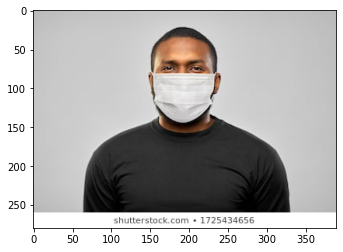

In [20]:
# get and open an image from web
image_url = 'https://image.shutterstock.com/image-photo/health-pandemic-safety-concept-african-260nw-1725434656.jpg'
response = requests.get(image_url)
image = response.content
img = Image.open(BytesIO(image))

print('Test image:')
plt.imshow(img)

In [21]:
# set our serverless serving function address 
addr = 'http://nuclio-{}-{}:8080'.format(hvdproj.name, hvdproj.func('serving').metadata.name)

headers = {'Content-type': 'image/jpeg'}
url = addr + f'/model/predict'

# invoke our function by https request
response = requests.post(url=url, 
                         data=image, 
                         headers=headers)
# decode our request
response.content.decode('utf-8')

'{"Mask probability": 0.8458470702171326}'

## Setup Kubeflow Pipeline
Register the source images directory as a project artifact (can be accessed by name)

In [23]:
hvdproj.log_artifact(
    'images', 
    target_path='https://s3.wasabisys.com/iguazio/data/masks_no_masks/archive.zip',
    artifact_path=mlrun.mlconf.artifact_path)

In [24]:
%%writefile workflow.py
from kfp import dsl
import mlrun

funcs = {}
epochs = 70
replicas = 2
batch_size = 32

def init_functions(functions: dict, project=None, secrets=None):
    '''
    This function will run before running the project.
    It allows us to add our specific system configurations to the functions
    like mounts or secrets if needed.

    In this case we will add Iguazio's user mount to our functions using the
    `mount_v3io()` function to automatically set the mount with the needed
    variables taken from the environment. 
    * mount_v3io can be replaced with mlrun.platforms.mount_pvc() for 
    non-iguazio mount

    :param functions:  <function_name: function_yaml> dict of functions in the
                        workflow
    :param project:    project object
    :param secrets:    secrets required for the functions for s3 connections and
                       such
    '''
    for f in functions.values():
        f.apply(mlrun.mount_v3io())            # On Iguazio (Auto-mount /User)
        # f.apply(mlrun.platforms.mount_pvc()) # Non-Iguazio mount
        
    functions['serving'].set_env('MODEL_CLASS', 'TFModel')
    functions['serving'].set_env('IMAGE_HEIGHT', '224')
    functions['serving'].set_env('IMAGE_WIDTH', '224')
    functions['serving'].set_env('ENABLE_EXPLAINER', 'False')
    functions['serving'].spec.min_replicas = 1
    
@dsl.pipeline(
    name='Image classification demo',
    description='Train an Image Classification TF Algorithm using MLRun'
)
def kfpipeline(
    # setup pipeline params
        image_archive='store:///images',
        target_path='/User/artifacts/fm-images',
        checkpoints_dir='/User/artifacts/models/checkpoints',
        model_name='mask_vs_no_mask'):

    # step 1: download images
    open_archive = funcs['utils'].as_step(name='download_and_open',
                                          handler='open_archive',
                                          params={'target_path': target_path},
                                          inputs={'archive_url': image_archive},
                                          outputs=['content'])

    # step 2: deploy out serveless training function and train a model
    # get the output of step 1 and use it as source dir
    source_dir = str(open_archive.outputs['content'])
    source_dir_images = source_dir +'/images'
    source_dir_annot = source_dir +'/annotations'
    
    # deploy our trainer function 
    deploy_train = funcs['trainer'].deploy_step(skip_deployed=True)
    deploy_train.after(open_archive)
    
    # train our model
    train = funcs['trainer'].as_step(name='train',
                                     params={'epochs'         : epochs,
                                             'batch_size'     : batch_size,
                                             'imgs'           : source_dir_images,
                                             'annot'          : source_dir_annot,
                                             'model_artifacts': checkpoints_dir},
                                     outputs=['model'],
                                     image=deploy_train.outputs['image'])
    
    # the image_pull_policy param is set in order to use the image 
    # we just built in the cell above
    train.container.set_image_pull_policy('Always')
    
    # set timeout in case the pipeline takes time
    train.set_timeout(214748364)
    train.after(deploy_train)
    
    # step 3: deploy the model using nuclio functions
    deploy = funcs['serving'].deploy_step(models={model_name: train.outputs['model']})
    deploy.after(train)

Overwriting workflow.py


In [25]:
# set the workflow in our MLRun project
hvdproj.set_workflow('main', os.path.join(os.path.abspath('./'),'workflow.py'), embed=True)

In [26]:
# save the workflow in our MLRun project
hvdproj.save()

In [27]:
# create dir for every pipeline run
artifact_path = os.path.abspath('./pipe/{{workflow.uid}}')

# run the pipeline
run_id = hvdproj.run(
    'main',
    arguments={'model_name': 'model'}, 
    artifact_path=artifact_path, 
    dirty=True, watch=True)

> 2020-12-20 13:11:34,430 [info] using in-cluster config.


> 2020-12-20 13:11:34,829 [info] Pipeline run id=97a2d0ee-ac3c-4ace-b027-2fd5663888c4, check UI or DB for progress
> 2020-12-20 13:11:34,830 [info] waiting for pipeline run completion


uid,start,state,name,results,artifacts
...efa3dd1d,Dec 20 13:13:55,completed,train,loss=0.2856277823448181accuracy=0.9140625,summary.htmlmodel-weightsmodel
...05c2fb90,Dec 20 13:11:44,completed,download_and_open,,content


### Test the deployed function from our pipeline (with URL)

Test image:


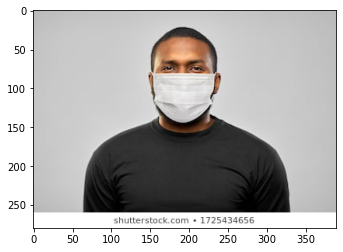

In [28]:
image_url = 'https://image.shutterstock.com/image-photo/health-pandemic-safety-concept-african-260nw-1725434656.jpg'
response = requests.get(image_url)
image = response.content
img = Image.open(BytesIO(image))

print('Test image:')
plt.imshow(img)

In [29]:
# set our serverless serving function address 
addr = 'http://nuclio-{}-{}:8080'.format(hvdproj.name, hvdproj.func('serving').metadata.name)

headers = {'Content-type': 'image/jpeg'}
url = addr + f'/model/predict'

# invoke our function by https request
response = requests.post(url=url, 
                         data=image, 
                         headers=headers)
# decode our request
response.content.decode('utf-8')

'{"Mask probability": 0.8379970788955688}'